In [78]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna
import pandas as pd
from pandas import read_csv

In [79]:
df = read_csv('dataset.csv')

In [84]:
X = df.filter(['group', 'perdelta_days_between_visits_15_30d',
 'k_var_days_between_visits_15d',
 'k_var_days_between_visits_1m',
 'k_var_days_between_visits_3m',
 'cheque_count_6m_g41',
 'cheque_count_6m_g40',
 'response_sms',
 'cheque_count_6m_g48',
 'cheque_count_12m_g38',
 'cheque_count_6m_g32',
 'response_viber',
 'k_var_count_per_cheque_6m_g27',
 'cheque_count_6m_g25',
 'cheque_count_12m_g32',
 'k_var_disc_share_15d_g24',
 'k_var_disc_share_6m_g24',
 'food_share_1m',
 'k_var_cheque_3m',
 'cheque_count_6m_g38',
 'cheque_count_3m_g25',
 'age',
 'food_share_15d',
 'cheque_count_12m_g41',
 'stdev_days_between_visits_15d',
 'k_var_sku_price_6m_g26', 'response_att'])
y = df['response_att']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

In [85]:
group_column = "group"
target_column = "response_att"

test_value = 1
control_value = 0

In [86]:
test_train = X_train.groupby([group_column]).get_group(test_value)
test_test = X_test.groupby([group_column]).get_group(test_value)
control_train = X_train.groupby([group_column]).get_group(control_value)
control_test = X_test.groupby([group_column]).get_group(control_value)

**Классифицируем покупателей, которые либо постоянные покупатели, либо падкие на скидки (на тесте)**

In [87]:
X_test_train = test_train.drop(columns=['group', 'response_att'])
y_test_train = test_train['response_att']
X_test_test = test_test.drop(columns=['group', 'response_att'])
y_test_test = test_test['response_att']

In [88]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.005, 0.015),
        "depth": trial.suggest_int("depth", 2, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian"]
        ),
        "used_ram_limit": "13gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 5, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)
    model.fit(X_test_train, y_test_train, verbose=False)

    y_pred = model.predict(X_test_test)
    accuracy = accuracy_score(y_pred, y_test_test)
    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)
study.best_params

[I 2020-06-27 16:19:29,386] Finished trial#0 with value: 0.892768934348855 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011356689854776584, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.809884893849155}. Best is trial#0 with value: 0.892768934348855.
[I 2020-06-27 16:19:47,419] Finished trial#1 with value: 0.8928141931646257 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.007970740690794783, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.3936752080021195}. Best is trial#0 with value: 0.892768934348855.
[I 2020-06-27 16:20:05,865] Finished trial#2 with value: 0.8923616050069181 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.007948348794440181, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.864149467504784}. Best is trial#2 with value: 0.8923616050069181.
[I 2020-06-27 16:20:23,601] Finished 

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.005035222135039391,
 'depth': 4,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 5.9686967634859185}

In [89]:
model_test = CatBoostClassifier(
    objective=study.best_params['objective'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    depth=study.best_params['depth'],
    boosting_type=study.best_params['boosting_type'],
    bootstrap_type=study.best_params['bootstrap_type'],
    bagging_temperature=study.best_params['bagging_temperature'])
model_test.fit(X_test_train, y_test_train)

Learning rate set to 0.088711
0:	learn: 0.6251551	total: 19.1ms	remaining: 19.1s
1:	learn: 0.5705651	total: 37.7ms	remaining: 18.8s
2:	learn: 0.5268789	total: 55.9ms	remaining: 18.6s
3:	learn: 0.4918942	total: 74.4ms	remaining: 18.5s
4:	learn: 0.4638674	total: 92.8ms	remaining: 18.5s
5:	learn: 0.4414118	total: 112ms	remaining: 18.6s
6:	learn: 0.4233863	total: 132ms	remaining: 18.7s
7:	learn: 0.4088965	total: 151ms	remaining: 18.8s
8:	learn: 0.3972246	total: 170ms	remaining: 18.7s
9:	learn: 0.3878048	total: 191ms	remaining: 18.9s
10:	learn: 0.3802144	total: 209ms	remaining: 18.8s
11:	learn: 0.3740741	total: 229ms	remaining: 18.8s
12:	learn: 0.3630094	total: 249ms	remaining: 18.9s
13:	learn: 0.3591947	total: 273ms	remaining: 19.2s
14:	learn: 0.3560863	total: 296ms	remaining: 19.4s
15:	learn: 0.3535496	total: 314ms	remaining: 19.3s
16:	learn: 0.3514764	total: 332ms	remaining: 19.2s
17:	learn: 0.3470669	total: 354ms	remaining: 19.3s
18:	learn: 0.3457458	total: 374ms	remaining: 19.3s
19:	le

161:	learn: 0.3132917	total: 3.05s	remaining: 15.8s
162:	learn: 0.3132910	total: 3.07s	remaining: 15.8s
163:	learn: 0.3132905	total: 3.09s	remaining: 15.8s
164:	learn: 0.3132900	total: 3.11s	remaining: 15.7s
165:	learn: 0.3132896	total: 3.13s	remaining: 15.7s
166:	learn: 0.3132893	total: 3.15s	remaining: 15.7s
167:	learn: 0.3132892	total: 3.16s	remaining: 15.7s
168:	learn: 0.3132890	total: 3.18s	remaining: 15.6s
169:	learn: 0.3132888	total: 3.2s	remaining: 15.6s
170:	learn: 0.3132888	total: 3.22s	remaining: 15.6s
171:	learn: 0.3122173	total: 3.23s	remaining: 15.6s
172:	learn: 0.3122168	total: 3.25s	remaining: 15.5s
173:	learn: 0.3122166	total: 3.27s	remaining: 15.5s
174:	learn: 0.3122163	total: 3.29s	remaining: 15.5s
175:	learn: 0.3122163	total: 3.31s	remaining: 15.5s
176:	learn: 0.3122163	total: 3.33s	remaining: 15.5s
177:	learn: 0.3122163	total: 3.35s	remaining: 15.4s
178:	learn: 0.3122163	total: 3.36s	remaining: 15.4s
179:	learn: 0.3122163	total: 3.38s	remaining: 15.4s
180:	learn: 0

320:	learn: 0.3034332	total: 6.03s	remaining: 12.8s
321:	learn: 0.3034331	total: 6.05s	remaining: 12.7s
322:	learn: 0.3034329	total: 6.07s	remaining: 12.7s
323:	learn: 0.3034329	total: 6.09s	remaining: 12.7s
324:	learn: 0.3034328	total: 6.11s	remaining: 12.7s
325:	learn: 0.3034328	total: 6.13s	remaining: 12.7s
326:	learn: 0.3034328	total: 6.14s	remaining: 12.6s
327:	learn: 0.3031235	total: 6.16s	remaining: 12.6s
328:	learn: 0.3028209	total: 6.18s	remaining: 12.6s
329:	learn: 0.3028208	total: 6.2s	remaining: 12.6s
330:	learn: 0.3016293	total: 6.22s	remaining: 12.6s
331:	learn: 0.3016289	total: 6.25s	remaining: 12.6s
332:	learn: 0.3016286	total: 6.26s	remaining: 12.5s
333:	learn: 0.3016283	total: 6.28s	remaining: 12.5s
334:	learn: 0.3013525	total: 6.3s	remaining: 12.5s
335:	learn: 0.3013525	total: 6.32s	remaining: 12.5s
336:	learn: 0.3012960	total: 6.34s	remaining: 12.5s
337:	learn: 0.3012957	total: 6.36s	remaining: 12.4s
338:	learn: 0.3012956	total: 6.38s	remaining: 12.4s
339:	learn: 0.

479:	learn: 0.2975609	total: 9.15s	remaining: 9.91s
480:	learn: 0.2975609	total: 9.16s	remaining: 9.89s
481:	learn: 0.2975609	total: 9.18s	remaining: 9.87s
482:	learn: 0.2975609	total: 9.2s	remaining: 9.85s
483:	learn: 0.2975609	total: 9.22s	remaining: 9.83s
484:	learn: 0.2975609	total: 9.24s	remaining: 9.81s
485:	learn: 0.2975609	total: 9.26s	remaining: 9.79s
486:	learn: 0.2975609	total: 9.28s	remaining: 9.78s
487:	learn: 0.2975609	total: 9.3s	remaining: 9.76s
488:	learn: 0.2974363	total: 9.32s	remaining: 9.74s
489:	learn: 0.2974316	total: 9.34s	remaining: 9.72s
490:	learn: 0.2974315	total: 9.36s	remaining: 9.7s
491:	learn: 0.2974315	total: 9.38s	remaining: 9.68s
492:	learn: 0.2972799	total: 9.39s	remaining: 9.66s
493:	learn: 0.2972799	total: 9.41s	remaining: 9.64s
494:	learn: 0.2972758	total: 9.43s	remaining: 9.62s
495:	learn: 0.2972758	total: 9.45s	remaining: 9.6s
496:	learn: 0.2972757	total: 9.47s	remaining: 9.58s
497:	learn: 0.2972757	total: 9.49s	remaining: 9.57s
498:	learn: 0.29

638:	learn: 0.2946939	total: 12.2s	remaining: 6.89s
639:	learn: 0.2946939	total: 12.2s	remaining: 6.87s
640:	learn: 0.2946939	total: 12.2s	remaining: 6.85s
641:	learn: 0.2946939	total: 12.2s	remaining: 6.83s
642:	learn: 0.2946939	total: 12.3s	remaining: 6.81s
643:	learn: 0.2944670	total: 12.3s	remaining: 6.79s
644:	learn: 0.2944670	total: 12.3s	remaining: 6.77s
645:	learn: 0.2944669	total: 12.3s	remaining: 6.75s
646:	learn: 0.2944669	total: 12.3s	remaining: 6.74s
647:	learn: 0.2944669	total: 12.4s	remaining: 6.72s
648:	learn: 0.2944669	total: 12.4s	remaining: 6.7s
649:	learn: 0.2944669	total: 12.4s	remaining: 6.68s
650:	learn: 0.2944669	total: 12.4s	remaining: 6.67s
651:	learn: 0.2944669	total: 12.4s	remaining: 6.64s
652:	learn: 0.2944669	total: 12.5s	remaining: 6.63s
653:	learn: 0.2944669	total: 12.5s	remaining: 6.61s
654:	learn: 0.2944669	total: 12.5s	remaining: 6.59s
655:	learn: 0.2944669	total: 12.5s	remaining: 6.57s
656:	learn: 0.2944669	total: 12.5s	remaining: 6.55s
657:	learn: 0

797:	learn: 0.2934250	total: 15.3s	remaining: 3.88s
798:	learn: 0.2934250	total: 15.3s	remaining: 3.86s
799:	learn: 0.2934250	total: 15.4s	remaining: 3.84s
800:	learn: 0.2933573	total: 15.4s	remaining: 3.82s
801:	learn: 0.2933573	total: 15.4s	remaining: 3.81s
802:	learn: 0.2933573	total: 15.4s	remaining: 3.79s
803:	learn: 0.2933573	total: 15.5s	remaining: 3.77s
804:	learn: 0.2933573	total: 15.5s	remaining: 3.75s
805:	learn: 0.2933500	total: 15.5s	remaining: 3.73s
806:	learn: 0.2933500	total: 15.5s	remaining: 3.71s
807:	learn: 0.2933038	total: 15.5s	remaining: 3.69s
808:	learn: 0.2933038	total: 15.6s	remaining: 3.67s
809:	learn: 0.2933038	total: 15.6s	remaining: 3.65s
810:	learn: 0.2933038	total: 15.6s	remaining: 3.63s
811:	learn: 0.2933027	total: 15.6s	remaining: 3.61s
812:	learn: 0.2933027	total: 15.6s	remaining: 3.59s
813:	learn: 0.2933027	total: 15.6s	remaining: 3.57s
814:	learn: 0.2933027	total: 15.7s	remaining: 3.56s
815:	learn: 0.2933027	total: 15.7s	remaining: 3.54s
816:	learn: 

956:	learn: 0.2928410	total: 18.6s	remaining: 836ms
957:	learn: 0.2928410	total: 18.6s	remaining: 816ms
958:	learn: 0.2928410	total: 18.6s	remaining: 797ms
959:	learn: 0.2928410	total: 18.7s	remaining: 778ms
960:	learn: 0.2928410	total: 18.7s	remaining: 758ms
961:	learn: 0.2928410	total: 18.7s	remaining: 739ms
962:	learn: 0.2928410	total: 18.7s	remaining: 719ms
963:	learn: 0.2927942	total: 18.7s	remaining: 700ms
964:	learn: 0.2927942	total: 18.8s	remaining: 681ms
965:	learn: 0.2927942	total: 18.8s	remaining: 661ms
966:	learn: 0.2927938	total: 18.8s	remaining: 642ms
967:	learn: 0.2927938	total: 18.8s	remaining: 622ms
968:	learn: 0.2927938	total: 18.8s	remaining: 603ms
969:	learn: 0.2927935	total: 18.9s	remaining: 583ms
970:	learn: 0.2927935	total: 18.9s	remaining: 564ms
971:	learn: 0.2927935	total: 18.9s	remaining: 544ms
972:	learn: 0.2927935	total: 18.9s	remaining: 525ms
973:	learn: 0.2927935	total: 18.9s	remaining: 505ms
974:	learn: 0.2927935	total: 18.9s	remaining: 486ms
975:	learn: 

**Классифицируем покупателей, которые либо падкие на скидки, либо не ходят покупать (на контроле)**

In [90]:
X_control_train = control_train.drop(columns=['group', 'response_att'])
y_control_train = control_train['response_att']
X_control_test = control_test.drop(columns=['group', 'response_att'])
y_control_test = control_test['response_att']

In [91]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.005, 0.015),
        "depth": trial.suggest_int("depth", 2, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian"]
        ),
        "used_ram_limit": "13gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 5, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)
    model.fit(X_control_train, y_control_train, verbose=False)

    y_pred = model.predict(X_control_test)
    accuracy = accuracy_score(y_pred, y_control_test)
    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)
study.best_params

[I 2020-06-27 16:21:17,296] Finished trial#0 with value: 0.8996948078455766 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.006258190733785106, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.540620787841645}. Best is trial#0 with value: 0.8996948078455766.
[I 2020-06-27 16:21:47,318] Finished trial#1 with value: 0.8993643450032074 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.005980550620716365, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.11672172698359}. Best is trial#1 with value: 0.8993643450032074.
[I 2020-06-27 16:22:16,795] Finished trial#2 with value: 0.9001030266508563 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.005789531599100681, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.635143139567004}. Best is trial#1 with value: 0.8993643450032074.
[I 2020-06-27 16:22:32,219]

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.005980550620716365,
 'depth': 4,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 9.11672172698359}

In [92]:
model_control = CatBoostClassifier(
    objective=study.best_params['objective'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    depth=study.best_params['depth'],
    boosting_type=study.best_params['boosting_type'],
    bootstrap_type=study.best_params['bootstrap_type'],
    bagging_temperature=study.best_params['bagging_temperature'])
model_control.fit(X_control_train, y_control_train)

Learning rate set to 0.064896
0:	learn: 0.6347671	total: 33.4ms	remaining: 33.3s
1:	learn: 0.5897376	total: 65.7ms	remaining: 32.8s
2:	learn: 0.5513612	total: 102ms	remaining: 33.9s
3:	learn: 0.5187407	total: 134ms	remaining: 33.2s
4:	learn: 0.4910204	total: 164ms	remaining: 32.7s
5:	learn: 0.4674651	total: 197ms	remaining: 32.7s
6:	learn: 0.4474490	total: 230ms	remaining: 32.7s
7:	learn: 0.4304123	total: 265ms	remaining: 32.9s
8:	learn: 0.4159053	total: 302ms	remaining: 33.3s
9:	learn: 0.4035383	total: 336ms	remaining: 33.2s
10:	learn: 0.3929916	total: 369ms	remaining: 33.2s
11:	learn: 0.3839837	total: 404ms	remaining: 33.2s
12:	learn: 0.3762826	total: 439ms	remaining: 33.3s
13:	learn: 0.3696912	total: 473ms	remaining: 33.3s
14:	learn: 0.3640435	total: 514ms	remaining: 33.7s
15:	learn: 0.3591989	total: 550ms	remaining: 33.8s
16:	learn: 0.3550644	total: 583ms	remaining: 33.7s
17:	learn: 0.3515229	total: 616ms	remaining: 33.6s
18:	learn: 0.3484389	total: 647ms	remaining: 33.4s
19:	learn

160:	learn: 0.3117148	total: 5.12s	remaining: 26.7s
161:	learn: 0.3117147	total: 5.15s	remaining: 26.7s
162:	learn: 0.3117147	total: 5.19s	remaining: 26.6s
163:	learn: 0.3117147	total: 5.22s	remaining: 26.6s
164:	learn: 0.3117147	total: 5.25s	remaining: 26.6s
165:	learn: 0.3117147	total: 5.28s	remaining: 26.5s
166:	learn: 0.3117147	total: 5.3s	remaining: 26.5s
167:	learn: 0.3117147	total: 5.33s	remaining: 26.4s
168:	learn: 0.3117147	total: 5.37s	remaining: 26.4s
169:	learn: 0.3117147	total: 5.39s	remaining: 26.3s
170:	learn: 0.3117147	total: 5.42s	remaining: 26.3s
171:	learn: 0.3104771	total: 5.45s	remaining: 26.2s
172:	learn: 0.3104769	total: 5.48s	remaining: 26.2s
173:	learn: 0.3104766	total: 5.51s	remaining: 26.2s
174:	learn: 0.3086488	total: 5.55s	remaining: 26.2s
175:	learn: 0.3086479	total: 5.58s	remaining: 26.1s
176:	learn: 0.3086471	total: 5.62s	remaining: 26.1s
177:	learn: 0.3085754	total: 5.65s	remaining: 26.1s
178:	learn: 0.3085748	total: 5.68s	remaining: 26.1s
179:	learn: 0

319:	learn: 0.2904813	total: 10.2s	remaining: 21.6s
320:	learn: 0.2904811	total: 10.2s	remaining: 21.6s
321:	learn: 0.2904809	total: 10.2s	remaining: 21.6s
322:	learn: 0.2904808	total: 10.3s	remaining: 21.5s
323:	learn: 0.2904806	total: 10.3s	remaining: 21.5s
324:	learn: 0.2904805	total: 10.3s	remaining: 21.4s
325:	learn: 0.2904804	total: 10.4s	remaining: 21.4s
326:	learn: 0.2904803	total: 10.4s	remaining: 21.4s
327:	learn: 0.2904802	total: 10.4s	remaining: 21.3s
328:	learn: 0.2904802	total: 10.4s	remaining: 21.3s
329:	learn: 0.2904801	total: 10.5s	remaining: 21.3s
330:	learn: 0.2904801	total: 10.5s	remaining: 21.2s
331:	learn: 0.2904800	total: 10.5s	remaining: 21.2s
332:	learn: 0.2904800	total: 10.6s	remaining: 21.2s
333:	learn: 0.2904799	total: 10.6s	remaining: 21.1s
334:	learn: 0.2904161	total: 10.6s	remaining: 21.1s
335:	learn: 0.2904161	total: 10.7s	remaining: 21.1s
336:	learn: 0.2903995	total: 10.7s	remaining: 21s
337:	learn: 0.2903994	total: 10.7s	remaining: 21s
338:	learn: 0.29

478:	learn: 0.2863562	total: 15.1s	remaining: 16.4s
479:	learn: 0.2862234	total: 15.1s	remaining: 16.4s
480:	learn: 0.2862233	total: 15.2s	remaining: 16.4s
481:	learn: 0.2862233	total: 15.2s	remaining: 16.3s
482:	learn: 0.2862233	total: 15.2s	remaining: 16.3s
483:	learn: 0.2862232	total: 15.3s	remaining: 16.3s
484:	learn: 0.2862232	total: 15.3s	remaining: 16.2s
485:	learn: 0.2862232	total: 15.3s	remaining: 16.2s
486:	learn: 0.2862232	total: 15.4s	remaining: 16.2s
487:	learn: 0.2862232	total: 15.4s	remaining: 16.1s
488:	learn: 0.2862232	total: 15.4s	remaining: 16.1s
489:	learn: 0.2862232	total: 15.4s	remaining: 16.1s
490:	learn: 0.2862232	total: 15.5s	remaining: 16s
491:	learn: 0.2862232	total: 15.5s	remaining: 16s
492:	learn: 0.2862232	total: 15.5s	remaining: 16s
493:	learn: 0.2862232	total: 15.6s	remaining: 15.9s
494:	learn: 0.2862232	total: 15.6s	remaining: 15.9s
495:	learn: 0.2862232	total: 15.6s	remaining: 15.9s
496:	learn: 0.2862232	total: 15.7s	remaining: 15.8s
497:	learn: 0.2862

637:	learn: 0.2831147	total: 20s	remaining: 11.3s
638:	learn: 0.2831147	total: 20s	remaining: 11.3s
639:	learn: 0.2830671	total: 20.1s	remaining: 11.3s
640:	learn: 0.2830671	total: 20.1s	remaining: 11.3s
641:	learn: 0.2830671	total: 20.1s	remaining: 11.2s
642:	learn: 0.2830656	total: 20.2s	remaining: 11.2s
643:	learn: 0.2830656	total: 20.2s	remaining: 11.2s
644:	learn: 0.2830164	total: 20.2s	remaining: 11.1s
645:	learn: 0.2830164	total: 20.3s	remaining: 11.1s
646:	learn: 0.2830164	total: 20.3s	remaining: 11.1s
647:	learn: 0.2830160	total: 20.3s	remaining: 11s
648:	learn: 0.2824548	total: 20.3s	remaining: 11s
649:	learn: 0.2824548	total: 20.4s	remaining: 11s
650:	learn: 0.2824547	total: 20.4s	remaining: 10.9s
651:	learn: 0.2824547	total: 20.4s	remaining: 10.9s
652:	learn: 0.2824547	total: 20.5s	remaining: 10.9s
653:	learn: 0.2824547	total: 20.5s	remaining: 10.8s
654:	learn: 0.2824547	total: 20.5s	remaining: 10.8s
655:	learn: 0.2824546	total: 20.6s	remaining: 10.8s
656:	learn: 0.2824546	

796:	learn: 0.2809375	total: 25s	remaining: 6.36s
797:	learn: 0.2809375	total: 25s	remaining: 6.33s
798:	learn: 0.2809375	total: 25s	remaining: 6.29s
799:	learn: 0.2809375	total: 25s	remaining: 6.26s
800:	learn: 0.2809375	total: 25.1s	remaining: 6.23s
801:	learn: 0.2809375	total: 25.1s	remaining: 6.2s
802:	learn: 0.2809375	total: 25.1s	remaining: 6.17s
803:	learn: 0.2809366	total: 25.2s	remaining: 6.14s
804:	learn: 0.2809366	total: 25.2s	remaining: 6.1s
805:	learn: 0.2809349	total: 25.2s	remaining: 6.07s
806:	learn: 0.2809349	total: 25.3s	remaining: 6.04s
807:	learn: 0.2809349	total: 25.3s	remaining: 6.01s
808:	learn: 0.2809349	total: 25.3s	remaining: 5.98s
809:	learn: 0.2809349	total: 25.4s	remaining: 5.95s
810:	learn: 0.2809349	total: 25.4s	remaining: 5.92s
811:	learn: 0.2809349	total: 25.4s	remaining: 5.88s
812:	learn: 0.2809349	total: 25.4s	remaining: 5.85s
813:	learn: 0.2808715	total: 25.5s	remaining: 5.82s
814:	learn: 0.2808715	total: 25.5s	remaining: 5.79s
815:	learn: 0.2808715	

955:	learn: 0.2790434	total: 29.9s	remaining: 1.37s
956:	learn: 0.2790312	total: 29.9s	remaining: 1.34s
957:	learn: 0.2790312	total: 29.9s	remaining: 1.31s
958:	learn: 0.2790312	total: 29.9s	remaining: 1.28s
959:	learn: 0.2790312	total: 30s	remaining: 1.25s
960:	learn: 0.2790312	total: 30s	remaining: 1.22s
961:	learn: 0.2790312	total: 30s	remaining: 1.19s
962:	learn: 0.2790312	total: 30.1s	remaining: 1.16s
963:	learn: 0.2790312	total: 30.1s	remaining: 1.12s
964:	learn: 0.2790312	total: 30.1s	remaining: 1.09s
965:	learn: 0.2790243	total: 30.2s	remaining: 1.06s
966:	learn: 0.2790240	total: 30.2s	remaining: 1.03s
967:	learn: 0.2790240	total: 30.2s	remaining: 999ms
968:	learn: 0.2790240	total: 30.2s	remaining: 968ms
969:	learn: 0.2790240	total: 30.3s	remaining: 937ms
970:	learn: 0.2790240	total: 30.3s	remaining: 906ms
971:	learn: 0.2790240	total: 30.3s	remaining: 874ms
972:	learn: 0.2790240	total: 30.4s	remaining: 843ms
973:	learn: 0.2790240	total: 30.4s	remaining: 812ms
974:	learn: 0.2790

In [93]:
# Конец

In [165]:
import numpy as np
first = np.array(model_test.predict_proba(X_test.drop(columns=['group']))[:,0])
second = np.array(model_control.predict_proba(X_test.drop(columns=['group']))[:,1])

In [166]:
uplift = []
for i in range(len(first)):
    uplift.append(min(first[i], second[i]))

In [167]:
uplift = first + second

In [168]:
uplift

array([0.69253021, 0.70569317, 0.72361297, ..., 1.21141199, 1.21650073,
       1.22215491])

In [169]:
X_test['uplift'] = uplift
X_test['response_att'] = y_test

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [170]:
def custom_metric(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 1]['response_att'].sum() / \
                   answers[answers['group'] == 1].shape[0]
    answers_control = answers[answers['group'] == 0]['response_att'].sum() / \
                      answers[answers['group'] == 0].shape[0]
    return (answers_test - answers_control) * 100

In [176]:
from sklearn.metrics import accuracy_score

print(custom_metric(X_test, take_top_ratio=0.25))
#print(accuracy_score(y_pred, y_test))
#print(np.sum(y_pred) / y_pred.shape[0])
#print(np.sum(y_test) / y_test.shape[0])

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.3201508143285732


In [172]:
! pip install seaborn

0


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


100
200
300
400
500
600
700
800
900
1000


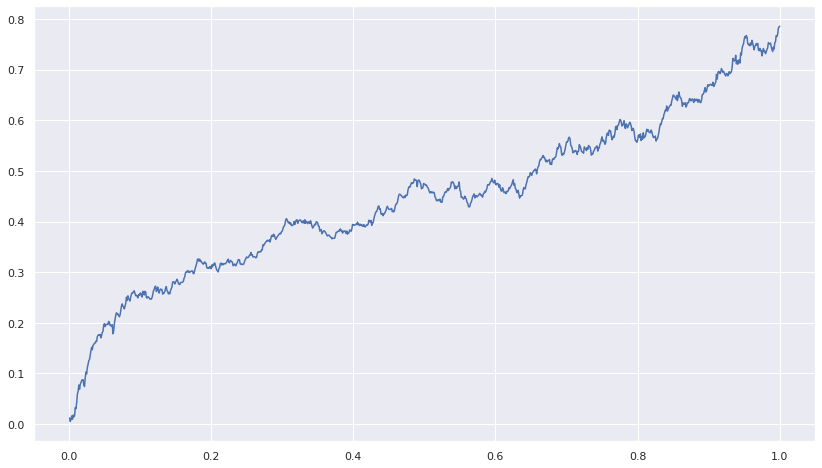

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
x = []
answers = []
num = 1000
for i in range(0, num + 1):
    if i % 100 == 0:
        print(i)
    x.append(1.0 * i / num)
    answers.append(custom_metric(X_test, take_top_ratio=1.0 * i/ num) * (1.0 * i / num))
    
plt.figure(figsize=(14,8))
plt.plot(x, answers)

0


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


100
200
300
400
500
600
700
800
900
1000


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


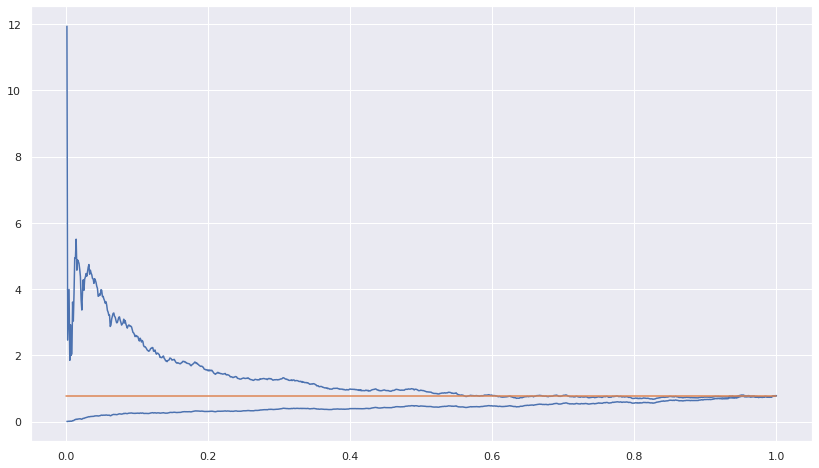

In [175]:
for i in range(0, num + 1):
    if i % 100 == 0:
        print(i)
    x.append(1.0 * i / num)
    answers.append(custom_metric(X_test, take_top_ratio=1.0 * i/ num))

plt.figure(figsize=(14,8))
plt.plot(x, answers)
stupid = custom_metric(X_test, take_top_ratio=1.0)
plt.plot([0, 1], [stupid, stupid])
plt.show()